In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

from sklearn.utils import shuffle

from catboost import CatBoostRegressor

In [2]:
data = pd.read_csv('data/combined_df.csv')
data = data[
    (data['Year'] >= 2020) &
    (data['Headliner'].str.contains('"', na=False)) &
    (~data['Support'].isna()) &
    (data['Genre'] != 'Family Entertainment')
  ]
data['Event Date'] = pd.to_datetime(data['Event Date'])
data['day_of_week'] = data['Event Date'].dt.day_of_week
data = data.sort_values(by='Year', ascending=True)
data.head(3)

C:\Users\sarah\AppData\Local\Temp\ipykernel_28304\3837815048.py:1: DtypeWarning: Columns (2,3,6,7,8,9,10,28) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/combined_df.csv')


,Event Date,Headliner,sp artist_name,sp artist_genre,sp followers,sp popularity,yt name,yt Channel ID,yt Title,yt Description,...,Genre,Avg. Tickets Sold,Avg. Gross USD,Avg. Event Capacity,Avg. Capacity Sold,Ticket Price Min USD,Ticket Price Max USD,Ticket Price Avg. USD,Month,day_of_week
109682,2020-01-01,"""Hangover Ball""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Pop / Rock,1119.0,26255.00,1700.0,65%,22.0,42.00,23.46,1,2
105467,2020-02-22,"""Lit AF Tour""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Comedy,8154.0,640687.00,20000.0,40%,45.0,150.00,78.57,2,5
105446,2020-02-22,"""Winter Jam""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Christian, Pop / Rock",8771.0,204841.18,12950.0,67%,15.0,49.99,23.35,2,5


In [3]:
# check for missing values
print(f'Missing sp data: {sum(data["sp followers"].isna())} rows')
print(f'Missing population data: {sum(data["Total population"].isna())} rows')
print(f'Missing yt data: {sum(data["yt Subscriber Count"].isna())} rows')
print(f'Missing monthly listeners data: {sum(data["monthly_listeners"].isna())} rows')

Missing sp data: 2258 rows
Missing population data: 2258 rows
Missing yt data: 2265 rows
Missing monthly listeners data: 213 rows


In [4]:
top_20_markets = data['Market'].value_counts().iloc[:20].index
one_hot_encoded = pd.get_dummies(data['Market'])
one_hot_encoded = one_hot_encoded[top_20_markets]
data = data.join(one_hot_encoded)

## Model 1

In [13]:
features = ['Avg. Event Capacity',
            'Ticket Price Min USD', 
            'Ticket Price Max USD',
            'Year',
            'monthly_listeners',
            'Month',
            'day_of_week'] + list(top_20_markets)

In [14]:
X = data[features]
y = data['Avg. Gross USD']
X = X.dropna()
y = y[X.index]

In [15]:
cat_model = CatBoostRegressor(loss_function='RMSE', verbose=0)

rkf = RepeatedKFold(n_splits=5, n_repeats=30, random_state=42)

cv_rmse = np.sqrt(-cross_val_score(cat_model, X, y, cv=rkf, scoring='neg_mean_squared_error'))
cv_mae = -cross_val_score(cat_model, X, y, cv=rkf, scoring='neg_mean_absolute_error')
cv_r2 = cross_val_score(cat_model, X, y, cv=rkf, scoring='r2')

print("CatBoost Regressor Cross-Validation Performance:")
print("Cross-Validation RMSE: Mean =", cv_rmse.mean())
print("Cross-Validation MAE: Mean =", cv_mae.mean())
print("Cross-Validation R^2: Mean =", cv_r2.mean())

CatBoost Regressor Cross-Validation Performance:
Cross-Validation RMSE: Mean = 326338.8421348717
Cross-Validation MAE: Mean = 114481.7431404035
Cross-Validation R^2: Mean = 0.846287926131925


## Model 2

In [5]:
features = ['Avg. Event Capacity',
            'Ticket Price Min USD', 
            'Ticket Price Max USD',
            'Year',
            'monthly_listeners',
            'Month',
            'day_of_week',
            'Number of Shows',
            'Support_Total_Monthly_Listeners',
            'Company Type',
            'Market',
            'Promoter'
           ] + list(top_20_markets)

In [6]:
X = data[features]
y = data['Avg. Gross USD']
X = X.dropna()
y = y[X.index]

In [7]:
columns_to_convert = ['Year', 'Month', 'day_of_week']
X[columns_to_convert] = X[columns_to_convert].astype(str)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

cat_model = CatBoostRegressor(loss_function='RMSE', verbose=0, cat_features=['Company Type', 'Market', 'Promoter'])
cat_model.fit(X_train, y_train)

y_pred = cat_model.predict(X_val)

rmse = root_mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("CatBoost Regressor Performance on Validation Set:")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R^2: {r2}")

CatBoost Regressor Performance on Validation Set:
RMSE: 316971.21158563363
MAE: 122700.40897422296
R^2: 0.9046533108678646


In [9]:
cat_model.get_feature_importance()

array([5.08754915e+01, 1.68080651e+01, 9.26747837e+00, 1.53734742e+00,
       4.50352099e+00, 1.53939980e+00, 3.84981485e+00, 1.14135858e+00,
       5.23143213e+00, 2.63964899e+00, 7.36539145e-01, 7.59550769e-01,
       4.65730532e-01, 1.33423842e-01, 2.56825945e-02, 8.66272397e-04,
       1.39135552e-01, 2.01180879e-02, 8.20765126e-03, 1.31443729e-02,
       7.43811610e-03, 9.47745376e-03, 1.43174756e-02, 6.11784890e-02,
       0.00000000e+00, 8.66850321e-02, 1.84761432e-02, 3.72747017e-02,
       2.59027289e-03, 4.59939024e-02, 1.27757573e-02, 7.83610979e-03])

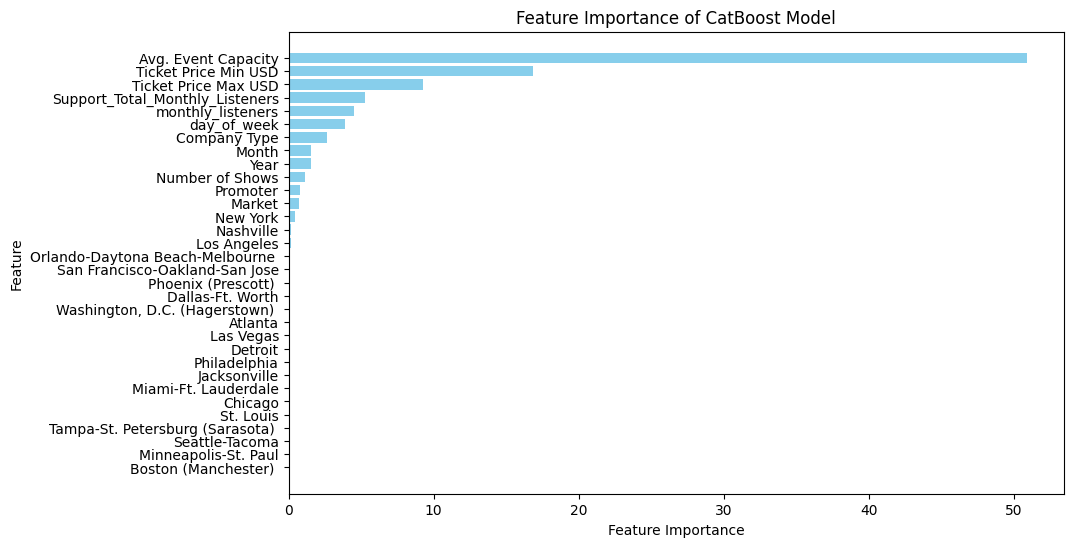

In [10]:
# Map features to their importance
feature_names = features  # Use the same order as in your data
importance_scores = cat_model.feature_importances_

# Sort by importance
sorted_indices = np.argsort(importance_scores)[::-1]
sorted_features = [feature_names[i] for i in sorted_indices]
sorted_importance = importance_scores[sorted_indices]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importance, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of CatBoost Model')
plt.gca().invert_yaxis()
plt.show()

### Repeat with Cross Validation

In [11]:
# Initialize the model
cat_model = CatBoostRegressor(loss_function='RMSE', verbose=0, cat_features=['day_of_week', 'Month', 'Year', 'Company Type', 'Market', 'Promoter'])

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=8)
rmse_scores = []
mae_scores = []
r2_scores = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Train the model
    cat_model.fit(X_train, y_train)
    
    # Predict on the validation set
    y_pred = cat_model.predict(X_val)
    
    # Compute metrics
    rmse_scores.append(mean_squared_error(y_val, y_pred, squared=False))
    mae_scores.append(mean_absolute_error(y_val, y_pred))
    r2_scores.append(r2_score(y_val, y_pred))

# Calculate average metrics
avg_rmse = np.mean(rmse_scores)
avg_mae = np.mean(mae_scores)
avg_r2 = np.mean(r2_scores)

print("CatBoost Regressor K-Fold Cross-Validation Performance:")
print(f"Average RMSE: {avg_rmse}")
print(f"Average MAE: {avg_mae}")
print(f"Average R^2: {avg_r2}")

C:\Users\sarah\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\sarah\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\sarah\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\sarah\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarnin

CatBoost Regressor K-Fold Cross-Validation Performance:
Average RMSE: 347811.7277726105
Average MAE: 121817.17148723154
Average R^2: 0.8262819628731629


C:\Users\sarah\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### TimeSeries Split

In [12]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Lists to store results for each split
rmse_scores = []
mae_scores = []
r2_scores = []

# Loop through splits
print("Time-Series Cross-Validation Results:")
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    # Split the data
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    cat_model = CatBoostRegressor(loss_function='RMSE', verbose=0, cat_features=['Company Type', 'Market', 'Promoter'])
    cat_model.fit(X_train, y_train)
    
    # Predict on validation set
    y_pred = cat_model.predict(X_val)
    
    # Calculate metrics
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    # Append metrics to lists
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    
    # Print metrics for this split
    print(f"  Split {i + 1}: RMSE = {rmse:.4f}, MAE = {mae:.4f}, R^2 = {r2:.4f}")

# Calculate and print averages
print("\nAverage Performance Across Splits:")
print(f"  Average RMSE: {np.mean(rmse_scores):.4f}")
print(f"  Average MAE: {np.mean(mae_scores):.4f}")
print(f"  Average R^2: {np.mean(r2_scores):.4f}")


Time-Series Cross-Validation Results:


C:\Users\sarah\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Split 1: RMSE = 282544.5018, MAE = 150944.0272, R^2 = 0.8758


C:\Users\sarah\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Split 2: RMSE = 280623.3253, MAE = 127088.6107, R^2 = 0.8588


C:\Users\sarah\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Split 3: RMSE = 732244.5726, MAE = 167198.7523, R^2 = 0.6938


C:\Users\sarah\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Split 4: RMSE = 376149.9328, MAE = 132832.4527, R^2 = 0.7817
  Split 5: RMSE = 187000.4945, MAE = 104914.5818, R^2 = 0.7985

Average Performance Across Splits:
  Average RMSE: 371712.5654
  Average MAE: 136595.6849
  Average R^2: 0.8017


C:\Users\sarah\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
